In [43]:
from ionqvision.ansatze.ansatz_library import AngleEncoder
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.circuit import ParameterVector
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from ionqvision.ansatze import VariationalAnsatz
import numpy as np
import symengine as symeng
from math import ceil, log
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp
# encoder = AngleEncoder(num_qubits=4)

In [44]:
class CustomZFeatureMapEncoder(VariationalAnsatz):
    """
    Implement a quantum circuit for encoding.
    """
    def __init__(self, num, reps = 1, param_prefix="x"):
        super().__init__(num)

        x = ParameterVector(param_prefix, num)
        self.compose(ZFeatureMap(num, reps=reps, insert_barriers=True).decompose(), inplace = True)

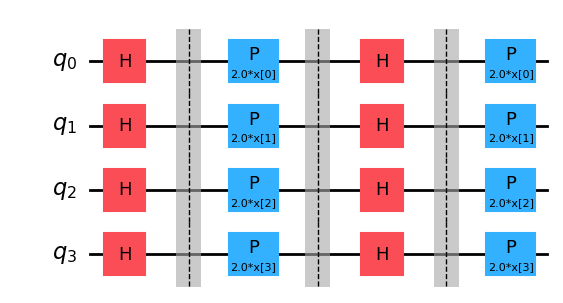

In [45]:
# implementing the ansatz
encoder =CustomZFeatureMapEncoder(4, reps = 2)
encoder.draw("mpl")

In [46]:
class CustomEfficientSU2(VariationalAnsatz):
    """
    Implement a quantum circuit for replicating the EfficientSU2 ansatz.
    """
    def __init__(self, num_qubits, reps, entanglement, param_prefix="θ"):
        super().__init__(num_qubits)

        theta = ParameterVector(param_prefix, num_qubits)
        self.compose(EfficientSU2(num_qubits=num_qubits, reps=reps, entanglement=entanglement, insert_barriers=True).decompose(), inplace = True)

In [47]:
class BrickworkLayoutAnsatz(VariationalAnsatz):
    
    def __init__(self, num_qubits, num_layers, params=None, prefix=None, blk_sz=1, qubits=None, initial_state=None):
        super().__init__(num_qubits)
        if initial_state is not None:
            self.compose(initial_state, inplace=True)
            self.barrier()

        num_blocks = ceil(num_layers * (num_qubits - 1) / 2)
        if params is None:
            if prefix is None:
                prefix = "θ"
            params = [ParameterVector(prefix + str(j), blk_sz) for j in range(num_blocks)]
        else:
            if not len(params) == num_blocks:
                raise ValueError(f"params must have length ceil(num_layers * (num_qubits - 1) / 2)")

        param_it = iter(params)
        if qubits is None:
            qubits = list(range(num_qubits))
        for j in range(num_layers):
            top_idx = j % 2
            while top_idx < len(qubits) - 1:
                self.two_qubit_block(next(param_it), qubits[top_idx], qubits[top_idx+1])
                top_idx += 2

    def two_qubit_block(self, theta, q1, q2):
        """
        Add a single-parameter two-qubit "brick" to ``self``.

        Assumes ``theta`` is a list or ``ParameterVector`` of length 1.
        """
        self.cz(q1, q2)
        self.ry(theta[0], q1)
        self.ry(theta[0], q2)

In [48]:
class QCNNAnsatz(VariationalAnsatz):
    r"""
    Implement the Quantum Convolutional Network Ansatz (QCNN) as described in
    :cite:t:`2019:qcnn`.

    The quasi-local unitary $U_i$'s are entangling two-qubit gates with $6$
    variational parameters.
    They are laid out in a brickwork pattern with ``filter_depth`` layers.

    The pooling operations are implemented by two-qubit controlled rotations,
    with $2$ variational parameters.

    The circuit starts with ``num_qubits`` active qubits and then half the
    remaining qubits are discarded after each pooling operation until only a
    single active qubit remains. This final qubit is measured and the result is
    used for binary classification.

    The convolution and pooling layers were updated to reflect the Qiskit version of a QCNN
    """
    class ConvolutionBrickwork(BrickworkLayoutAnsatz):
        """
        Implement the convolution filters for the :class:`.QCNNAnsatz`.
        """
        
        def __init__(self, num_qubits, num_layers, prefix=None, qubits=None, initial_state=None):
            super().__init__(num_qubits, num_layers, blk_sz=3, prefix=prefix, qubits=qubits, initial_state=initial_state)
        
        def two_qubit_block(self, theta, q1, q2):
            conv_op = QuantumCircuit(2, name="CONV")
            # conv_op.ry(theta[0], 0)
            # conv_op.ry(theta[1], 1)
            # conv_op.rxx(theta[2], 0, 1)
            #conv_op = QuantumCircuit(2)
            conv_op.rz(-np.pi / 2, 1)
            conv_op.cx(1, 0)
            conv_op.rz(theta[0], 0)
            conv_op.ry(theta[1], 1)
            conv_op.cx(0, 1)
            conv_op.ry(theta[2], 1)
            conv_op.cx(1, 0)
            conv_op.rz(np.pi / 2, 0)
            self.append(conv_op.to_instruction(), [q1, q2])

    class PoolingLayer(BrickworkLayoutAnsatz):
        """
        Implement the pooling layer for the :class:`.QCNNAnsatz`.
        """
        def __init__(self, num_qubits, prefix=None, qubits=None):
            super().__init__(num_qubits, 1, blk_sz=3, prefix=prefix, qubits=qubits)
            
        def two_qubit_block(self, theta, q1, q2):
            pool_op = QuantumCircuit(2, name="POOL")
            # pool_op.crz(theta[0], 1, 0)
            # target = QuantumCircuit(2)
            pool_op.rz(-np.pi / 2, 1)
            pool_op.cx(1, 0)
            pool_op.rz(theta[0], 0)
            pool_op.ry(theta[1], 1)
            pool_op.cx(0, 1)
            pool_op.ry(theta[2], 1)
            self.append(pool_op.to_instruction(), [q1, q2])

    def __init__(self, num_qubits, filter_depth=2, initial_state=None):
        num_layers = int(log(num_qubits, 2))
        if abs(log(num_qubits, 2) - num_layers) > 1e-6:
            raise ValueError("num_qubits must be a power of 2")

        super().__init__(num_qubits)
        if initial_state is not None:
            self.compose(initial_state, inplace=True)

        for k in range(num_layers):
            qubits = list(range(0, num_qubits, 2**k))
            theta = ParameterVector("θ", num_qubits)
            conv = QCNNAnsatz.ConvolutionBrickwork(num_qubits, filter_depth, prefix="C" + str(k), qubits=qubits)
            self.compose(conv, inplace=True)
            
            pool = QCNNAnsatz.PoolingLayer(num_qubits, prefix="P" + str(k), qubits=qubits)
            self.compose(pool, inplace=True)

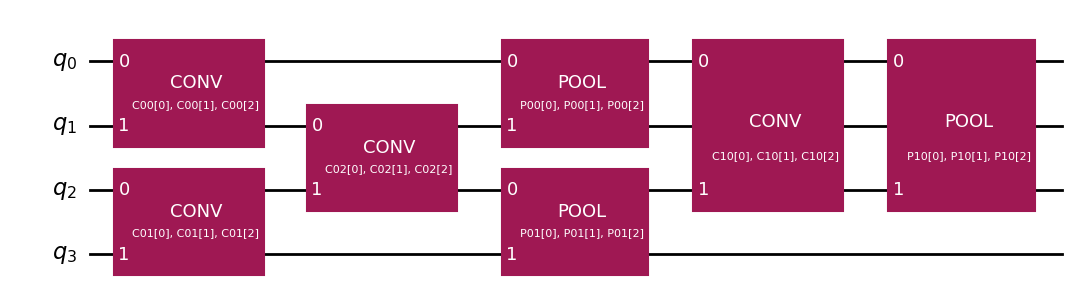

In [49]:
## creating the QCNN ansatz
ansatz = QCNNAnsatz(num_qubits=4)
ansatz.draw("mpl")

In [50]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of ZZZZ
def feature_creation(n):
    return [SparsePauliOp(["Z" + "Z"*(n-1)])]
            # SparsePauliOp(["I"*(n-1) + "Y"]), 
            # SparsePauliOp(["I"*(n-1)  + "Z"])]

quantum_features = feature_creation(4)

In [51]:
quantum_features

[SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j])]

In [52]:
from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features);

In [53]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

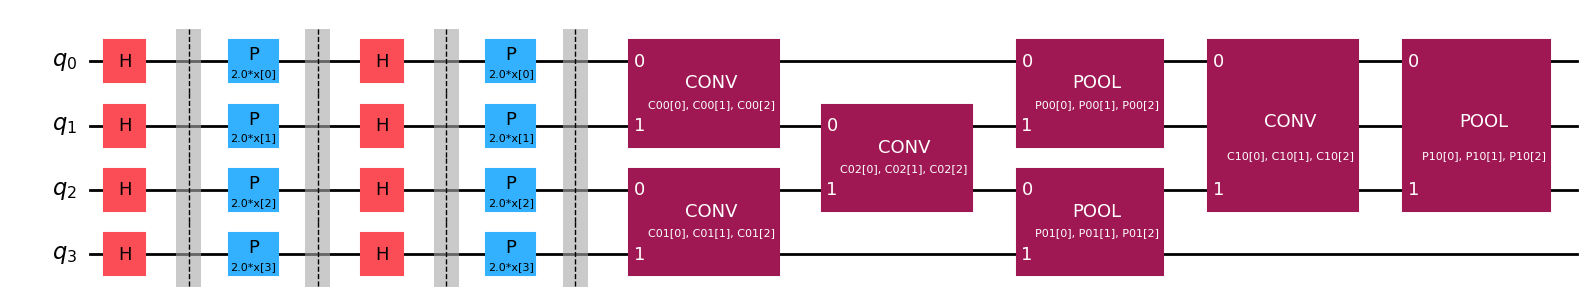

In [54]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl", fold=-1)

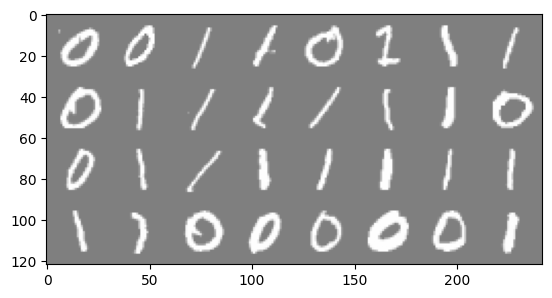

In [55]:
# Verify the images loaded correctly
classifier.visualize_batch()

In [56]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=300, test_size=100)

train_set

CPU times: user 124 ms, sys: 86.2 ms, total: 211 ms
Wall time: 215 ms


Dataset MNIST
    Number of datapoints: 300
    Root location: ./mnist-train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [57]:
train_set[0][0].shape

torch.Size([1, 28, 6])

In [58]:
np.array(train_set[0][0].shape)

array([ 1, 28,  6])

In [59]:
mat = np.array(train_set[8][0])/np.sqrt(np.sum(np.array(train_set[8][0])**2))
new_mat = mat.reshape(168, 1)
zero_vector = np.zeros((int((2**np.ceil(np.log2(168)) - 168)/2), 1))
long_vector = np.concat((zero_vector, new_mat, zero_vector))
long_vector_reshaped = long_vector.reshape(1, 256)

/tmp/ipykernel_36048/508853306.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mat = np.array(train_set[8][0])/np.sqrt(np.sum(np.array(train_set[8][0])**2))


In [60]:
np.sum(long_vector_reshaped**2)

np.float64(0.999999986513429)

epoch:   1 | loss: 0.705
lr: 0.0900 | processed     6/    6 batches per epoch in 197.15s (0.64s forward / 30.35s backward)
Model achieved 61.333%  accuracy on TRAIN set.
Model achieved 60.000%  accuracy on TEST set.

epoch:   2 | loss: 0.687
lr: 0.0900 | processed     6/    6 batches per epoch in 187.87s (0.58s forward / 29.41s backward)
Model achieved 56.333%  accuracy on TRAIN set.
Model achieved 51.000%  accuracy on TEST set.

epoch:   3 | loss: 0.683
lr: 0.0900 | processed     6/    6 batches per epoch in 199.77s (0.82s forward / 38.66s backward)
Model achieved 59.000%  accuracy on TRAIN set.
Model achieved 63.000%  accuracy on TEST set.



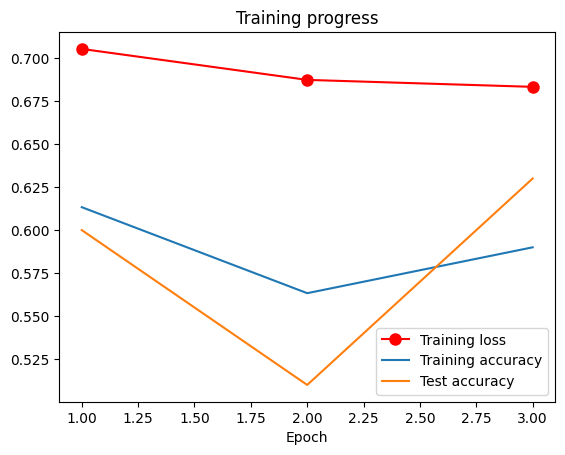

In [61]:
# Configure model training hyper parameters
config = {
    "epochs": 1,
    "lr": 0.09,
    "batch_size": 50,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 6,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

In [62]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

In [63]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

Submission received. Autograder in progress.


In [64]:
client.await_autograder_result(submission_id=submission_id)

{'_id': '6709d26ac5dcab8872686016',
 'submittedBy': 'ganiyubaraq@gmail.com',
 'status': 'succeeded',
 'statusMessage': 'Submission graded successfully.',
 'executionId': 'ionq-scquantum-59ldr',
 'executionSec': 62,
 'score': 58,
 'createdAt': '2024-10-12T01:35:38.958Z',
 'updatedAt': '2024-10-12T01:35:38.958Z',
 'success': True}